# <center> FUNDAMENTOS DE APRENDIZAJE AUTOMÁTICO <br> Y RECONOCIMIENTO DE PATRONES</center>
## <center> Práctico 6 </center>      

In [1]:
# Se importan las bibliotecas que se utilizarán
import numpy as np
import glob
import matplotlib
import matplotlib.pyplot as plt

from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix
from sklearn import svm
from sklearn.model_selection import PredefinedSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

from scipy import signal
from scipy.io import wavfile

import IPython.display as ipd
from IPython.display import Image

import time
import os

%matplotlib inline

## Objetivos

- Plantear la **maximización del margen** en el algoritmo SVM y su resolución en el **espacio dual**.
- Formular las ventajas prácticas que puede presentar resolver el **problema dual**.
- Adquirir cierta intuición en cuanto a la solución brindada por el algoritmo SVM mediante su aplicación para **separar** entre distintos tipos de **sonidos** utilizando sólo dos características.
- Aplicar SVM en un problema de mediana escala para **clasificar** entre 10 categorías de **sonidos urbanos**.
- **Optimizar** los parámetros de un **clasificador SVM** utilizando la biblioteca *scikit-learn*.
- Aplicar correctamente el mecanismo de **validación cruzada** como forma de estimar la bondad del clasificador.
- Interpretar la información birndada por una matriz de confusión.

## Lista de ejercicios

[Ejercicio 1](#Ejercicio1): Formulación del algoritmo SVM       
[Ejercicio 2](#Ejercicio2): Separando sonidos con características intuitivas   
[Ejercicio 3](#Ejercicio3): SVM en un problema de mediana escala multiclase   

<a id="Ejercicio1"></a>
## Ejercicio 1: Formulación del algoritmo SVM

El algoritmo $\textit{C-SVM}$ da lugar al siguiente problema de optimización:

\begin{align}\label{csvm} 
    \left\{ \begin{aligned}  
& \underset{\mathbf{w}, b, \mathbf{\xi}}{\min}
&  & f(\mathbf{w}, \mathbf{\xi}) = \frac{1}{2}||\mathbf{w}||^{2} + C \sum_{n=1}^{N} \xi_n \\
& \text{sujeto a} \\   
& & & y_n ( \mathbf{w}^T\Phi(x_n)  + b) \geq 1 - \xi_n \quad \forall n=1,\ldots,N\\  
& & & \xi_n \geq 0 \\   
   \end{aligned}   \right.  
\end{align} 

**Parte a)** Escribir el Lagrangiano $\mathcal{L}$ del problema. 

**Solución:**

$\mathcal{L} (\mathbf{w}, \mathbf{\xi}, \alpha, \beta,b,C)  = \frac{1}{2}w^Tw + C \sum_{n=1}^{N} \xi_n - \sum_{n=1}^{N} \alpha_n (\mathbf{w}^T\Phi(x_n)  + b) - 1 + \xi_n ) - \sum_{n=1}^{N} \beta_n \xi_n$ 

**Parte b)** Argumentar que el valor del Lagrangiano $\mathcal{L}$ está acotado superiormente por la función de costo original $f$. 

**Solución:**

Se puede argumentar de forma sencilla dado que en el lagragiano aparce explicitamente la funcion de costo $f$ a la cual se le restan elementos que son estrictamente positivos dado que los multiplicadores cumplen $\alpha_n \geq 0$ y $\beta_n \geq 0$. Luego, dadas las resticciones del problema dual se tiene que $\xi_n \geq 0$ y que $\mathbf{w}^T\Phi(x_n)  + b) - 1 + \xi_n \geq 0$

## El problema primal

**Parte c)** Se define la función $\theta_{\mathcal{P}}(\mathbf{w},b,\boldsymbol{\xi} )=\underset{\boldsymbol{\alpha}, \boldsymbol{\beta}; \alpha_n \geq 0, \beta_n \geq 0}{\max}\mathcal{L}(\mathbf{w},b,\boldsymbol{\xi}, \boldsymbol{\alpha}, \boldsymbol{\beta} ) $. Argumentar que resolver

$$
\underset{\mathbf{w}, b, \mathbf{\xi}}{\min} \theta_{\mathcal{P}}(\mathbf{w},b,\boldsymbol{\xi} )
$$

es equivalente a encontrar el mínimo de  $f(\mathbf{w}, \mathbf{\xi})$ con las restricciones del problema.

**Solución:** 

Para minimizar la funcion de costo sujeto a las restricciones, lo que se hace es escribir el lagrangiano donde se obtiene un funcional a minimizar. Como se observa en la expresion vista para el lagragiano, el minimo se obtiene minimizando los parametros $w,b,\xi$ y maximizando los multiplicadores $\alpha, \beta$ que al hacerlos maximos restan terminos positivos con mayor peso. 

## El Problema Dual

 Se define ahora la función $\textit{dual}$ $\theta_{\mathcal{D}}(\boldsymbol{\alpha}, \boldsymbol{\beta} )=\underset{\mathbf{w},b,\boldsymbol{\xi}}{\min}\mathcal{L}(\mathbf{w},b,\boldsymbol{\xi}, \boldsymbol{\alpha}, \boldsymbol{\beta} ) $.      
En general se cumple para el óptimo del problema dual $d^*$ que

$$
d^* = \underset{\boldsymbol{\alpha}, \boldsymbol{\beta}}{\max} \theta_{\mathcal{D}}(\boldsymbol{\alpha}, \boldsymbol{\beta}) \leq  \underset{\mathbf{w}, b, \mathbf{\xi}}{\min} \theta_{\mathcal{P}}(\mathbf{w},b,\boldsymbol{\xi} ) = p^*
$$
 
Sin embargo, en el caso en que tanto la función a optimizar $f$ como sus restricciones son convexas se cumple que $d^*$ coincide con $p^*$. Este es el caso de SVM.

Desde el punto de vista práctico resolver el problema $\textit{primal}$ implica maximizar respecto a los multiplicadores de Lagrange primero y luego minimizar respecto a los pesos y las variables $\textit{slack}$. Resolver el problema $\textit{dual}$ en cambio implica minimizar respecto a los pesos y las variables $\textit{slack}$ primero y luego maximizar respecto a los multiplicadores.


**Parte d)** Mostrar que el problema dual puede escribirse como:
\begin{align*}
    \left\{ \begin{aligned}  
& \underset{\boldsymbol{\alpha}}{\min}
& & \frac{1}{2}\boldsymbol{\alpha}^{T}\boldsymbol{Q}\boldsymbol{\alpha} - \mathbb{1}^{T}\boldsymbol{\alpha} \\
& \text{sujeto a} \\
& & & 0 \leq \alpha_n \leq C \\ 
& & & \sum_n \alpha_n y_n = 0 \\ 
   \end{aligned}   \right. 
\end{align*}
con $Q_{ij} = y_i y_j K(x_i,x_j)$

**Solución**    

Si se parte del lagragiano que se tenia anteriormente y se iguala a cero los siguiente gradientes y derivadas:

$$
\nabla_w \mathcal{L} = w - \sum_{n=1}^{N} \alpha_n y_n x_n = 0
$$

$$
\frac{\partial\mathcal{L}}{\partial b} = - \sum_{n=1}^{N} \alpha_n y_n = 0
$$

$$
\frac{\partial\mathcal{L}}{\partial \xi_n} = C - \alpha_n - \beta_n = 0
$$

De esta forma hallamos el punto critico del lagragiano. Luego sustituimos estos resultados en el lagragiano que se tenia obteniendo:

$$
\mathcal{L} (\mathbf{\alpha}) = \sum_{n=1}^{N} \alpha_n - \frac{1}{2}\sum_{n=1}^{N}\sum_{m=1}^{N} y_ny_m \alpha_n\alpha_m x_n^Tx_m
$$
Este lagragiano es equivalente al problema de minimizacion con restricciones que se encuntra arriba:

**Parte e)** Mencione por qué puede resultar más conveniente resolver el problema dual.

**Respuesta:**   

Para el problema primal se tienen un problema de d+1 (w y b) incognitas mientras que en el problema dual se tiene un problema de N incognitas (que son los multiplicadores $\alpha$). Por lo tanto puede ser conveniente el problema dual para resolver problemas donde la dimension del modelo sea muy alta.  

<a id="Ejercicio2"></a>
## Ejercicio 2: Separando sonidos con características intuitivas

En los ejercicios 2 y 3 de este práctico se trabajará con la base de datos **Urban Sound**.

## Base de datos Urband Sound

La base de datos está conformada por una serie de fragmentos de audios en las que se escuchan sonidos característicos de un entorno urbano. En concreto, la base cuenta con sonidos pertenecientes a las siguientes 10 categorías:  
    
    0-  aire acondicionado  
    1-  bocina de auto  
    2-  niños jugando  
    3-  ladrido de perros  
    4-  taladrado  
    5-  motor moderando  
    6-  disparo de arma de fuego  
    7-  martillo neumático  
    8-  sirena  
    9-  música callejera  

Los fragmentos tienen una duración de 4 segundos. Los fragmentos fueron extraídos de grabaciones más grandes utilizando ventanas de 4 segundos solapadas entre sí por 2 segundos.  

Los datos se provén separados en 10 *folds*, tomando en cuenta que en *folds* distintos NO existen extractos de un mismo audio.  

### Distribución de la base de datos

La siguiente celda lee la *metadata* de la base de datos y genera un gráfico que muestra la distribución de las clases según los *folds* y la cantidad de audios por clase.

<ipython-input-2-679c1601fc9d>:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(folders)


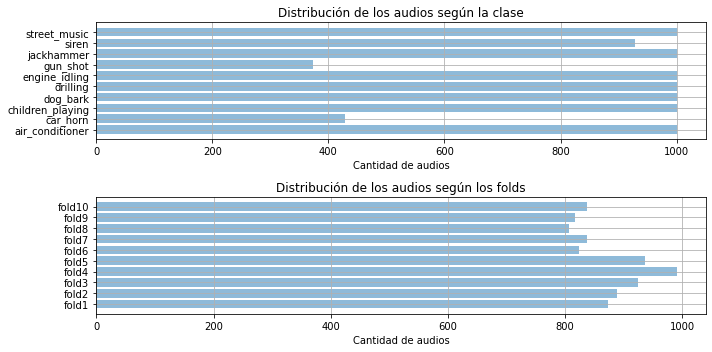

In [2]:
# función auxiliar
def split_data(all_data):
    '''
    Separa los datos en 10 Folds predefinidos
    '''
    folders = [[], [], [], [], [], [], [], [], [], []]
    for ln in range(len(all_data)):
        folders[int(all_data[ln][5]) - 1].append(all_data[ln])
    for ln in range(len(folders)):
        folders[ln] = np.array(folders[ln])
    return np.array(folders)


file_metadata_path = 'dataset/metadata'
metadata = []

with open(os.path.join(file_metadata_path, 'UrbanSound8K.csv'), 'r') as file_metadata:
    line1 = file_metadata.readline()
    metadata.append(line1.split('\n')[0].split(','))
    for line in file_metadata:
        metadata.append(line.split('\n')[0].split(','))
        metadata[-1][5] = metadata[-1][5].zfill(2)

headers = metadata[0]
all_data = np.array(metadata[1:])

folders = split_data(all_data)

uniqueValues, occurCount = np.unique(all_data[:, 6], return_counts=True)
objects = ('air_conditioner', 'car_horn', 'children_playing', 'dog_bark', 
           'drilling', 'engine_idling', 'gun_shot', 'jackhammer', 'siren', 
           'street_music')
y_pos = np.arange(len(objects))
plt.figure(figsize=(10,5))
plt.subplot(2,1,1)
plt.barh(y_pos, occurCount, align='center', alpha=0.5)
plt.yticks(y_pos, objects)
plt.xlabel('Cantidad de audios')
plt.title('Distribución de los audios según la clase')
plt.grid()

plt.subplot(2,1,2)
_, occurCount2 = np.unique(all_data[:, 5], return_counts=True)
objects2 = ('fold1', 'fold2', 'fold3', 'fold4', 'fold5', 
            'fold6', 'fold7', 'fold8', 'fold9', 'fold10')
y_pos2 = np.arange(len(objects2))
plt.barh(y_pos, occurCount2, align='center', alpha=0.5)
plt.yticks(y_pos2, objects2)
plt.xlabel('Cantidad de audios')
plt.title('Distribución de los audios según los folds')
plt.grid()
plt.tight_layout()

Funciones auxiliares para plotear las señales de los audios 

In [3]:
# ejecutar y seguir
def mostrar_senhales(path_audios, n_fold, n_clase):
    '''
    Muestra las señales de la clase n_clase almacenadas en el fold n_fold
    Entrada:
      path_audios: directorio donde se almacena la base
      n_fold: fold a utilizar
      n_clase: número de clase a mostrar
    '''
    cont = 0
    folder = os.path.join(path_audios, 'fold'+str(n_fold), str(n_clase))
    tam = len(glob.glob(os.path.join(folder, '*.npy')))
    fig, axes = plt.subplots(tam, 1, figsize=(10, 10))
    for path_au in glob.glob(os.path.join(folder, '*.npy')):
        y = np.load(path_au)
        axes[cont].plot(np.arange(len(y)), y)
        axes[cont].grid()
        axes[cont].axis([0, len(y), -1.2, 1.2])
        cont += 1   
    axes[0].set_title('fold %d, clase %d' % (n_fold, n_clase))
    fig.tight_layout()
        
def comparar_dos_clases(path_audios, fold1, clase1, fold2, clase2):
    '''
    Entrada:
      path_audios: directorio donde se almacena la base
      fold1: fold donde se encuentran las primeras señales a comparar
      clase1: clase de las primeras señales a comparar
      fold2: fold donde se encuentran las segundas señales a comparar
      clase2: clase de las segundas señales a comparar
    '''
    path1 = os.path.join(path_audios, 'fold'+str(fold1), str(clase1), '*.npy')
    path2 = os.path.join(path_audios, 'fold'+str(fold2), str(clase2), '*.npy')
    tam_clas_mayor = np.max([len(glob.glob(path1)), 
                            len(glob.glob(path2))])
    fig, axes = plt.subplots(nrows=tam_clas_mayor, ncols=2, figsize=(15, 10))
    for fold, clase in zip([fold1, fold2],[clase1, clase2]):
        cont = 0
        path = os.path.join(path_audios, 'fold'+str(fold), str(clase), '*.npy')
        for path_au in glob.glob(path):
            y = np.load(path_au)
            if clase == clase1:
                axes[cont, 0].plot(np.arange(len(y)), y)
                axes[cont, 0].grid()
                axes[cont, 0].axis([0, len(y), -1.2, 1.2])
            else:
                axes[cont, 1].plot(np.arange(len(y)), y)
                axes[cont, 1].grid()
                axes[cont, 1].axis([0, len(y), -1.2, 1.2])
            cont += 1
        if clase == clase1:
            axes[0, 0].set_title('fold %d, clase %d' % (fold, clase))
        else:
            axes[0, 1].set_title('fold %d, clase %d' % (fold, clase))
    fig.tight_layout()

In [4]:
path_audios = 'dataset/audios'

En este ejercicio se buscará separar las siguientes tres clases de sonidos pertenecientes al *fold 3*:

    5-  motor moderando  
    6-  disparo de arma de fuego  
    7-  martillo neumático

La distribución de los fragmentos por clase en el *fold 3* es la siguiente:

    - motor moderando = 107 fragmentos obtenidos a partir de 10 grabaciones
    - disparo de arma de fuego = 36 fragmentos obtenidos a partir de 12 grabaciones
    - martillo neumático = 120 fragmentos obtenidos a partir de 5 grabaciones

La siguiente celda muestra las señales correspondientes a una determinada clase y un determinado *fold*.

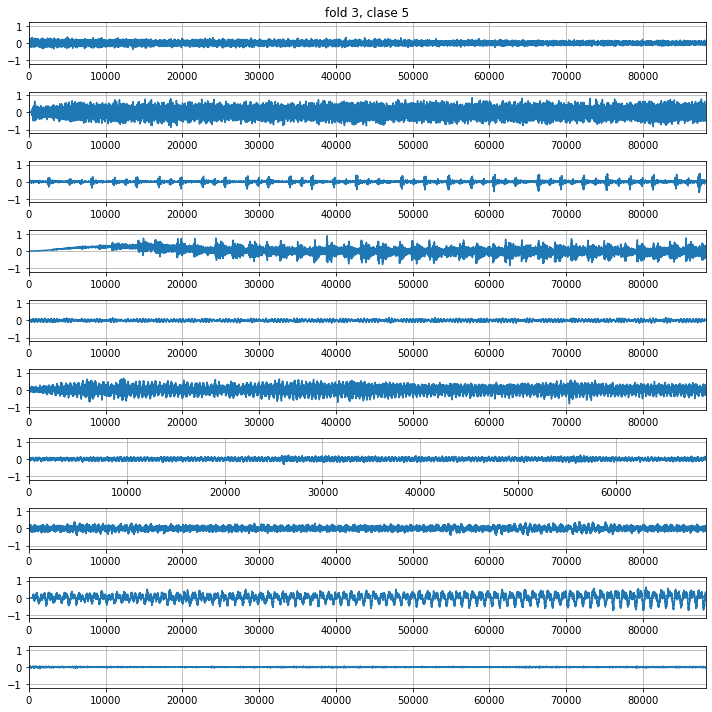

In [5]:
fold_to_show=3
class_to_show= 5
mostrar_senhales(path_audios, fold_to_show, class_to_show)

La siguiente celda permite comparar las señales de *folds* y/o clases diferentes.

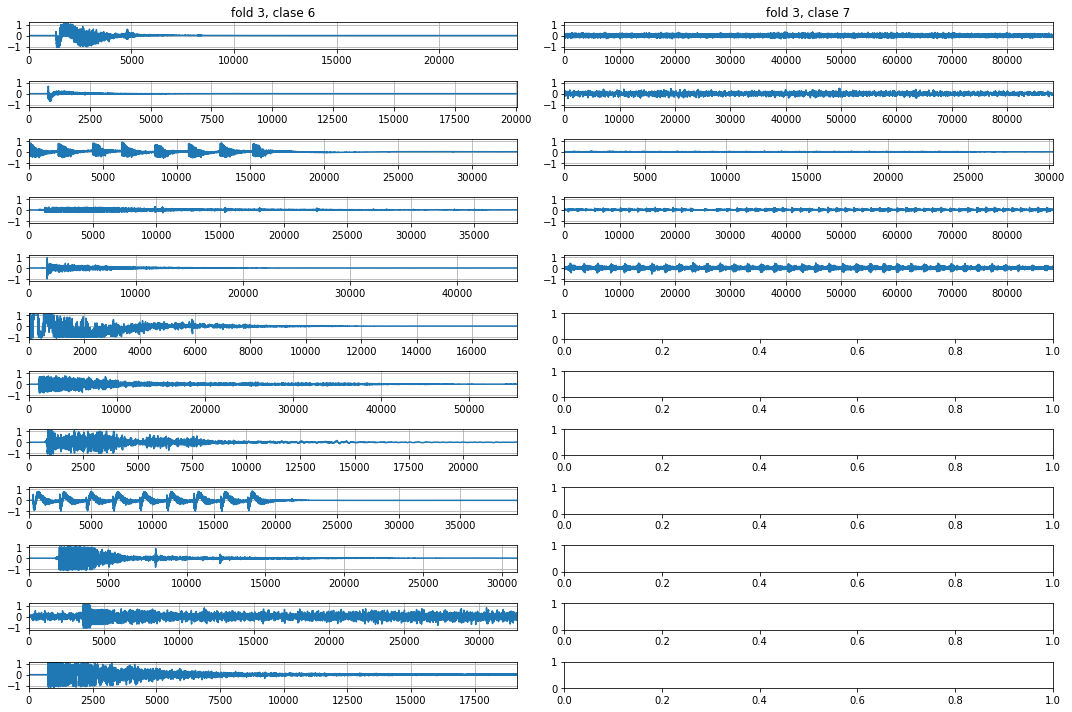

In [6]:
fold1_to_compare=3
class1_to_compare=6
fold2_to_compare=3
class2_to_compare=7
comparar_dos_clases(path_audios, fold1_to_compare, class1_to_compare, fold2_to_compare, class2_to_compare)

## Características

En el presente ejercicio se buscará ganar intuición sobre como trabaja el clasificador SVM, para ello se describirá el comportamiento de las señal utilizando dos características temporales intuitivas.

Cada fragmento se divide en ventanas solapadas en un 50% de 2048 muestras y para cada ventana se calculan las siguientes características:

 - ZCR (Zero-Crossing-Rate): la cantidad de cruces por cero de las muestras de la señal.
    
 - RMS (Root-Mean-Square): la raíz del valor cuadrático medio de las muestras de la señal, también conocida como medida de la energía de la señal.
    
$$
x_{RMS} = \sqrt{\frac{1}{N}\sum_{i=1}^{N}x_{i}^2}
$$

Finalmente se obtiene un único valor de *ZCR* y *RMS* representativo del fragmento, aplicando sobre los valores obtenidos en todas las ventanas una de las siguientes operaciones: mean(), max(), min() o std_dev() 

La extracción de características fue realizada previamente y la siguiente celda las levanta:

In [7]:
# se levantan las características (ZCR, RMS) calculadas para los audios de cada fold
folders_features = np.load('dataset/linealfeat_all_folds.npy', allow_pickle=True) # objeto python de largo 10
n_folds = len(folders_features)
print('Se levantaron las características precalculadas de %d folds' % n_folds)
print('El primer fold tiene %d segmentos de audio' % len(folders_features[0]))

Se levantaron las características precalculadas de 10 folds
El primer fold tiene 873 segmentos de audio


A continuación se definen funciones necesarias para extraer y plotear las características. Ejecutar y seguir.

In [8]:
def features_from_arrays(features_from_fold, tipo_c1='', tipo_c2=''):
    '''
    Entrada:
        features_from_fold: características calculadas en el fold
        tipo_c1: string que puede ser mean, min, max, std o vacio para calcular el ZCR
        tipo_c2: string que puede ser mean, min, max, std o vacio para calcular el RMS

    Salida:
        numpy array con dos características:
            ZCR: ratio de cruces por cero, en el caso de tener entrada vacia se devuelve el array entero
            RMS: raíz del error cuadrático medio, en el caso de tener entrada vacia se devuelve el array entero
    '''
    for i in range(len(features_from_fold)):
        if tipo_c1 == 'mean':
            features_from_fold[i][0] = np.mean(features_from_fold[i][0])
        elif tipo_c1 == 'min':
            features_from_fold[i][0] = np.min(features_from_fold[i][0])
        elif tipo_c1 == 'max':
            features_from_fold[i][0] = np.max(features_from_fold[i][0])
        elif tipo_c1 == 'std':
            features_from_fold[i][0] = np.std(features_from_fold[i][0])

        if tipo_c2 == 'mean':
            features_from_fold[i][1] = np.mean(features_from_fold[i][1])
        elif tipo_c2 == 'min':
            features_from_fold[i][1] = np.min(features_from_fold[i][1])
        elif tipo_c2 == 'max':
            features_from_fold[i][1] = np.max(features_from_fold[i][1])
        elif tipo_c2 == 'std':
            features_from_fold[i][1] = np.std(features_from_fold[i][1])

    return features_from_fold



def plot_features(features, labels, op_type1_1, op_type2_1):
    
    plt.figure()
    clases = np.unique(labels).astype(int)
    for c in clases:
        indices = labels==c
        plt.scatter(features[indices,0], features[indices,1], label=objects[c])
    plt.grid()
    plt.legend()
    plt.xlabel('ZCR ' + op_type1_1)
    plt.ylabel('RMS ' + op_type2_1)
    plt.title('Características calculadas')

## Ejercicios

**Ejercicio:** En primera instancia se intentará separar las clases 6 y 7 del fold 3 utilizando como características el ZCR promedio y la desviación estandar del RMS.  Las siguientes celdas generan el conjunto de datos a utilizar para ello.

In [9]:
def generar_conjunto_entrenamiento(folds, clases, op_feat1, op_feat2):
    '''
    Entrada:
        folds: folds a utilizar
        clases: clases a utilizar
        op_feat1: operación a realizar con los valores ZCR del segmento
        op_feat1: operación a realizar con los valores RMS del segmento
    Salida:
        features: características calculadas
        labels: etiquetas asociadas a las caracteríticas
    '''
    features = []
    labels = []
    for c in range(len(clases)):
        for fold in folds:
            f_c = folders_features[fold-1][folders[fold-1][:, -2] == np.str(clases[c])]
            f_c = features_from_arrays(f_c, tipo_c1=op_feat1, tipo_c2=op_feat2)
            features.append(f_c)
            labels.append(clases[c]*np.ones(len(f_c)))
    features = np.vstack(np.asarray(features))
    labels = np.concatenate(np.asarray(labels))
    
    plot_features(features, labels, op_feat1, op_feat2)
    return features, labels

/home/emiliano/miniconda3/envs/fuaa/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


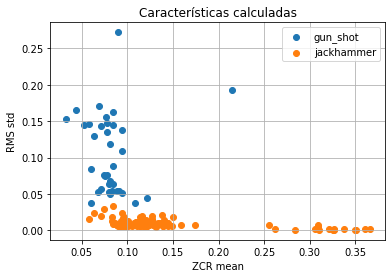

In [10]:
clases_a_separar=[6,7]
Xtrain, ytrain = generar_conjunto_entrenamiento([3], clases_a_separar, 'mean', 'std')

**Pregunta:** ¿Le parece razonable la distribución de los puntos para el caso del disparo y el martillo neumático? ¿Qué comportamiento de la señal logran capturar las características elegidas?

**Respuesta:**       

El contenido espectral del tiro es una delta al principio y despues se extinge rapido. En consecuencia el contenido espectral de un tiro es menor, pero su desviacon es mayor respecto al martillo que es constante en el tiempo. 

## Clasificación 

En esta parte se compararán las soluciones de *Regresión Logística* y *SVM*. En el caso de SVM se trabajará con un *kernel linear*.

In [11]:
# función auxiliar para mostrar el resultado de la clasificación
def mostrar_superficie_decision(features, labels, clf_svm, clf_logreg):
    
    plt.figure(figsize=(10,10))
    clases = np.unique(labels).astype(int)
    for c in clases:
        indices = labels==c
        plt.scatter(features[indices,0], features[indices,1], label=objects[c])

    # plot the decision svm
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    # create grid to evaluate model
    xx = np.linspace(xlim[0], xlim[1], 30)
    yy = np.linspace(ylim[0], ylim[1], 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    Z = clf_svm.decision_function(xy).reshape(XX.shape)
    # plot decision boundary and margins
    ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    # plot support vectors
    ax.scatter(clf_svm.support_vectors_[:, 0], clf_svm.support_vectors_[:, 1], s=100,
               linewidth=1, facecolors='none', edgecolors='k', label='vectores de soporte')

    # plot regresión logística
    w_log = clf_logreg.coef_[0]
    b_log = clf_logreg.intercept_[0]
    #ap = -w_log[0] / w_log[1]
    #ymin = features[:, 1].min()
    #ymax = features[:, 1].max()
    #if ap >= 0:
    #    xmin = np.max([(ymin + b_log / w_log[1]) / ap, features[:, 0].min()])
    #    xmax = np.min([(ymax + b_log / w_log[1]) / ap, features[:, 0].max()])
    #else:
    #    xmin = np.max([(ymax + b_log / w_log[1]) / ap, features[:, 0].min()])
    #    xmax = np.min([(ymin + b_log / w_log[1]) / ap, features[:, 0].max()])
    xmin = features[:, 0].min()
    xmax = features[:, 0].max()
    xx = np.linspace(xmin, xmax)
    yy = -( w_log[0] * xx + b_log) / w_log[1]
    plt.plot(xx, yy, 'r-', label='límite de decisión de regresión logística')
    
    plt.legend()
    plt.xlabel('ZCR ')
    plt.ylabel('RMS ')
    plt.grid()
    plt.show()

**Ejercicio:** Completar la siguiente celda y comparar las soluciones brindadas por *Regresión Logística* y *SVM* con parámetros por defecto.   

El clasificador SVM tiene [7 7] vectores soporte.
El tamaño del márgen es 0.35077686439548


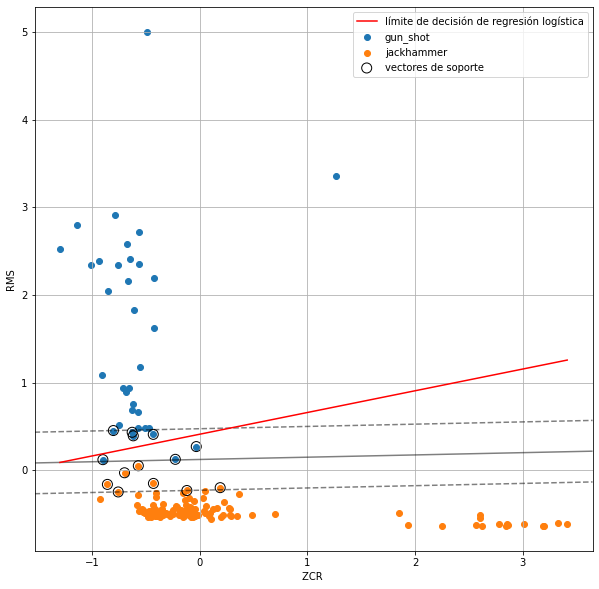

In [12]:
#################################################################################################################
########################  EMPIEZA ESPACIO PARA COMPLETAR CODIGO  ################################################
#################################################################################################################

# Se estandarizan las características
scaler = StandardScaler(copy=True, with_mean=True, with_std=True).fit(Xtrain)
Xtrain_std = scaler.transform(Xtrain)

# Se entrena el clasificador de regresión logística 
clf_logreg = LogisticRegression(solver='sag', max_iter=10000).fit(Xtrain_std,ytrain)


# Se entrena el clasificador svm con kernel linear
clf_svm = svm.SVC(kernel='linear').fit(Xtrain_std,ytrain)


# se obtiene el número de vectores de soporte del clasificador 
num_vec_sop = clf_svm.n_support_


# se obtiene el tamaño del margen
tam_margen = 1/(np.linalg.norm(clf_svm.coef_, ord = 2))

#################################################################################################################
########################  TERMINA ESPACIO PARA COMPLETAR CODIGO  ################################################
#################################################################################################################

print('El clasificador SVM tiene {} vectores soporte.'.format(num_vec_sop))
print('El tamaño del márgen es {}'.format(tam_margen))
# Se muestra el resultado de los clasificadores entrenados anteriormente
#plot_clasificadores(Xtrain, clf_svm, clf_logreg, c1, c2, op_type1_1, op_type2_1)
mostrar_superficie_decision(Xtrain_std, ytrain,clf_svm, clf_logreg )

**Ejercicio:** ¿Cómo varía el número de soportes en función de $C$? ¿Y el margen? Puede ser útil crear una nueva celda y generar una gráfica que muestre la variación de estas cantidades con $C$.

In [13]:
clf_svm = svm.SVC(kernel='linear').fit(Xtrain_std,ytrain)
print(1)
print(clf_svm.n_support_)
print(1/(np.linalg.norm(clf_svm.coef_, ord = 2)))

clf_svm = svm.SVC(kernel='linear', C=1e1).fit(Xtrain_std,ytrain)
print(1e1)
print(clf_svm.n_support_)
print(1/(np.linalg.norm(clf_svm.coef_, ord = 2)))

clf_svm = svm.SVC(kernel='linear', C=1e3).fit(Xtrain_std,ytrain)
print(1e3)
print(clf_svm.n_support_)
print(1/(np.linalg.norm(clf_svm.coef_, ord = 2)))


1
[7 7]
0.35077686439548
10.0
[3 3]
0.22411910181729294
1000.0
[2 1]
0.03569722686610234


**Respuesta:**  
Cuando C es mayor se penaliza mas el error y en consecuencia se tiene un margen mas pequeno. Si el C es pequeno se admiten mas errores y en consecuencia se obtiene un margen mayor.  

## Clasificación SVM multiclase

En esta parte se utilizará SVM para clasificar entre tres clases pertenecientes a un mismo *fold*.

La siguiente celda define una función auxiliar para mostrar el resultado de la clasificación

In [14]:
def plot_svm_multiclase(X, Y, clf, op_type1_1, op_type2_1):
    
    plt.figure(figsize=(10,10))
    # plot the decision
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    h = .01
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired, alpha=.1)
#     # plot support vectors
    plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100,
               linewidth=1, facecolors='none', edgecolors='k', label='support vectors')

#     plt.legend()
    plt.scatter(X[:, 0], X[:, 1], c=Y, cmap=plt.cm.Paired, edgecolors='k')
    plt.xlabel('ZCR ' + op_type1_1)
    plt.ylabel('RMS ' + op_type2_1)
    plt.grid()
    plt.show()

In [15]:
# Se define el fold y las clases a separar
fold = 3
c1 = 5
c2 = 6
c3 = 7

# Se calculan las características
op_type1_1 = 'mean'
op_type2_1 = 'std'

class_features = []
for i in range(10):
    fi = folders_features[fold-1][folders[fold-1][:, -2] == np.str(i)]
    fi = features_from_arrays(fi, tipo_c1=op_type1_1, tipo_c2=op_type2_1)
    class_features.append(fi)
class_features = np.array(class_features)

<ipython-input-15-110928c33613>:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  class_features = np.array(class_features)


Se arma el conjunto de entrenamiento con las clases elegidas

In [16]:
Xtrain_3 = np.vstack([class_features[c1], class_features[c2], class_features[c3]])
ytrain_3 = np.hstack([np.zeros(len(class_features[c1])), np.ones(len(class_features[c2])), np.ones(len(class_features[c3]))*2])

**Ejercicio:** Entrenar un clasificador SVM que logre separar correctamente completamente el conjunto de entrenamiento. 

<ipython-input-14-21d0de08cc60>:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired, alpha=.1)


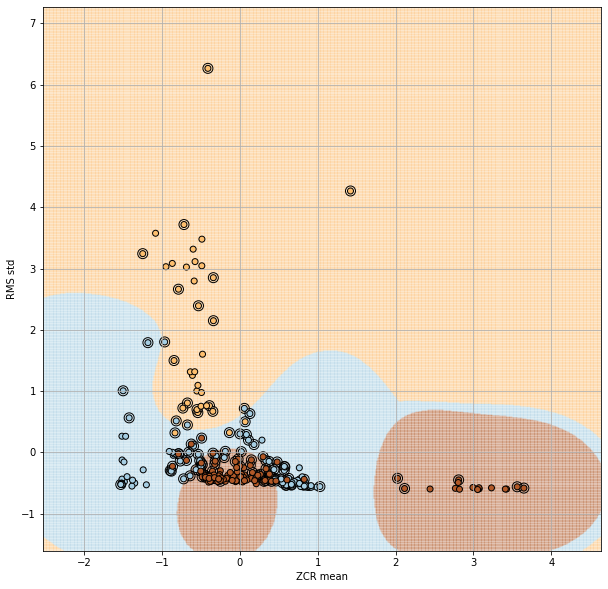

El clasificador SVM tiene [49 18 41]/263 vectores soporte.


In [17]:
####################################################################################################################
###########################  EMPIEZA ESPACIO PARA COMPLETAR CODIGO  ################################################
####################################################################################################################

scaler = StandardScaler(copy=True, with_mean=True, with_std=True).fit(Xtrain_3)
Xtrain_3_std = scaler.transform(Xtrain_3)


clf_svm = svm.SVC(kernel='rbf', gamma=1).fit(Xtrain_3_std,ytrain_3)
num_vec_sop = clf_svm.n_support_

E_in = 1-clf_svm.score(Xtrain_3_std, ytrain_3)

####################################################################################################################
###########################  TERMINA ESPACIO PARA COMPLETAR CODIGO  ################################################
####################################################################################################################
plot_svm_multiclase(Xtrain_3_std, ytrain_3, clf_svm, op_type1_1, op_type2_1)
print('El clasificador SVM tiene {}/{} vectores soporte.'.format(num_vec_sop, len(Xtrain_3)))

**Pregunta:** ¿Cuál es el criterio que usa la implementación SVC para clasificar múltiples clases?

**Respuesta:**  

La SVC multiclase halla los vectores de soporte que maximizan el margen entre las clases (en una dimension alta) de forma que quedan determinados en el espacio difernetes regiones. Para cada clase se puede hacer svm de clasificacion biaria tomado la clase x y realiza el algoritmo uno a uno con cada clase para luego tener un modelo que es la combinacion de todos. Luego en escencia el SVM multiclase son varios svm de una clase que se realizan uno a uno. (one-a-one)

**Pregunta:** ¿Y en el caso de Regresión Logística? ¿Cómo se lleva a cabo la clasificación multiclase?

**Respuesta:**  


Para el caso de regresion logistica se realiza un metodo uno contra el resto. Es decir tomando una clase y dejando el resto en otra clase, y luego iterando para todas las clases.De esta forma se obtiene una solucion combinando todos los resultados. (on)

<a id="Ejercicio3"></a>
# Ejercicio 3: SVM en un problema de mediana escala multiclase

### Descripción del ejercicio

En este ejercicio se utilizará un clasificador SVM para separar los sonidos  urbanos de la base de datos *Urband Sound*. Se dividirán los *folds* en conjuntos de entrenamiento, validación y test. Los primeros 6 folds conformarán el conjunto de entrenamiento, los folds 7-8 el de validación y los folds 9-10 el de test.

### Características

Se utilizarán las mismas características que en el *paper* [A Dataset and Taxonomy for Urban Sound Research](http://www.justinsalamon.com/uploads/4/3/9/4/4394963/salamon_urbansound_acmmm14.pdf) que es el trabajo que presentó la base de datos. 

#### Coeficientes Cepstrales de Frecuencia Mel (MFCC)

Los Coeficientes Cepstrales de Frecuencia Mel (MFCC) son características que representan propiedades del espectro de tiempo corto de una señal de audio. En particular, permiten capturar la evolución de la envolvente espectral, lo que es de especial relevancia para discriminar el tipo de sonido. Por esta razón, son muy utilizados para el procesamiento y análisis de señales de voz, sonidos ambientales y música.


El cálculo de los MFCC se representa en el esquema de la siguiente figura. La señal de entrada $x[n]$ es dividida en tramas temporales solapadas, mediante una ventana suavizante $w[n]$ y se calcula la magnitud del espectro de cada trama $|X[k]|$ usando la DFT. La magnitud del espectro pasa por un banco de filtros que sigue aproximadamente la respuesta en frecuencia de la percepción auditiva humana. Los componentes de frecuencia que pasan por cada filtro del banco $V_l[k]$ son ponderados por la respuesta del filtro y se suma su magnitud al cuadrado, lo que corresponde a un cálculo de energía. Luego se calcula el logaritmo de la señal de salida y se convierte al dominio del tiempo usando la Transformada de Coseno Discreto (DCT). Además de volver al dominio del tiempo, la DCT descompone los coeficientes de forma de que cada coeficiente tiene información diferente a la de los demás coeficientes. Es habitual conservar solo los primeros coeficientes de la DCT, los cuales se relacionan con la envolvente espectral de la señal. Para capturar la evolución temporal de los MFCC se suele calcular además la derivada de primer y segundo orden de cada coeficiente.  

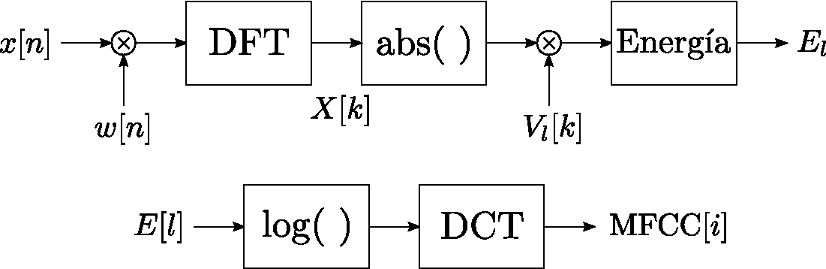

In [18]:
Image(filename="figuras/mfcc_bloques.png")

Para el cálculo de los MFCC que se usarán a continuación, se segmenta la señal de audio en tramas de tamaño 23,2 ms con un 50% de solapamiento entre tramas y se aplica un banco de filtros con 40 bandas Mel distribuidas entre 0 y 22050 Hz. A la salida de la DCT se conservan los primeros 25 coeficientes MFCC. Luego, el comportamiento de cada coeficiente MFCC a lo largo de todas las tramas de un archivo de audio se describe calculando las siguientes características: mínimo, máximo, mediana, media, varianza,  asimetría, kurtosis y la media y varianza de la primera y segunda derivadas de la señal, resultando en un vector de características de dimensión 275.

A continuación se muestran los primeros 12 MFCC calculados para los dos archivos de ejemplo.

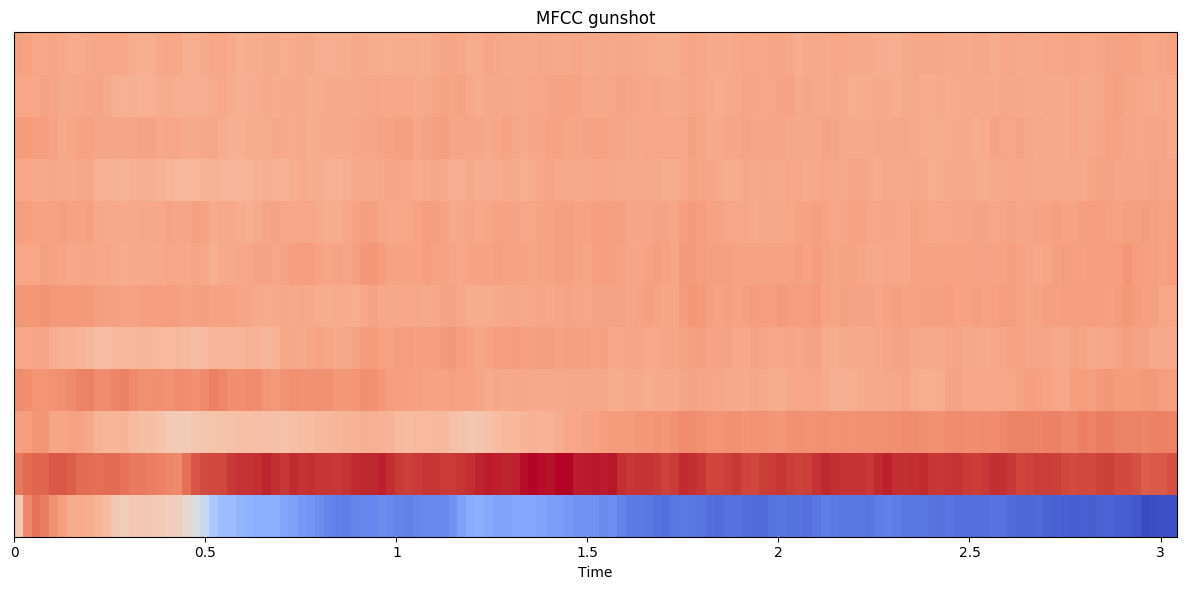

In [19]:
Image(filename="figuras/gunshot.png")

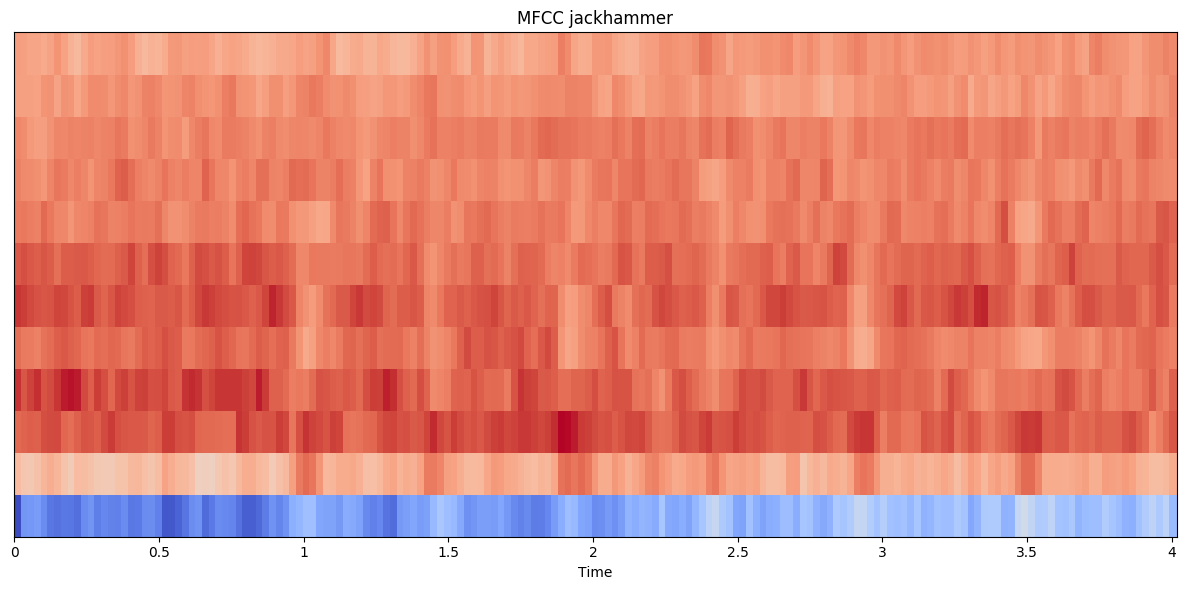

In [20]:
Image(filename="figuras/jackhammer.png")

Dado que la extracción de características lleva un tiempo no despreciable, las mismas fueron precalculadas. A continuación se levantan las mismas desde el directorio *dataset*.  

In [21]:
def extraer_caracteristicas(folds_list):
    '''
    Función que parsea los folds para generar conjuntos de entrenamiento/validación/test
    Entrada:
        folds_list: lista que contiene los folds que se quieren utilizar 
                    para construir el conjunto
    Salida:
        features: arreglo de tamaño (N, 275) que contiene las características extraídas 
                  de los folds
        labels: vector de tamaño (N,) que contiene las clases a la que pertenecen
                las muestras
        fold_indices: vector de tamaño (N,) que contiene a que fold pertenece la muestra
    '''
    data_list = []  # lista auxiliar que contiene los folds
    indices_list = []  # lista auxiliar que contiene los indices de los folds
    for foldNumber in folds_list:
        filename = 'dataset/' + "features_fold_" + str(foldNumber) + ".csv"
        data = np.loadtxt(filename, delimiter=',', skiprows=1)  # se lee un fold
        indices = foldNumber * np.ones(data.shape[0])  # se asocia un número de fold a cada dato
        data_list.append(data)  # se agrega la data del fold a la lista
        indices_list.append(indices)  # se agregan los indices a la lista de indices
    data = np.concatenate(data_list)
    fold_indices = np.concatenate(indices_list)
    features = data[:, :275]
    labels = data[:, 276]
    return features, labels, fold_indices

Se divide el conjunto de datos en *entrenamiento* y *validación*

In [22]:
# Se construye el conjunto de entrenamiento con los primeros seis folds
features_train, labels_train, fold_indices_train = extraer_caracteristicas([1,2,3,4,5,6])
print('El conjunto de entrenamiento cuenta con %d audios' % len(features_train))
# Se construye el conjunto de validación con los folds 7 y 8
features_val, labels_val, fold_indices_val = extraer_caracteristicas([7, 8])
print('El conjunto de validación cuenta con %d audios' % len(features_val))
# Los folds 9 y 10 se utilizarán para test. No se provén las etiquetas del conjunto de test
features_test, labels_test, _ = extraer_caracteristicas([9, 10])
print('El conjunto de test cuenta con %d audios' % len(features_test))

El conjunto de entrenamiento cuenta con 5435 audios
El conjunto de validación cuenta con 1644 audios
El conjunto de test cuenta con 1653 audios


## Parte 1: clasificador por defecto

Entrenar el clasificador SVM con parámetros por defecto utilizando el conjunto de entrenamiento. 

In [43]:
################################################################################
##########  EMPIEZA ESPACIO PARA COMPLETAR CODIGO  #############################
################################################################################

clf_svm = svm.SVC().fit(features_train,labels_train)

E_in = np.count_nonzero([clf_svm.predict(features_train) != labels_train])/len(features_train)

E_val = np.count_nonzero([clf_svm.predict(features_val) != labels_val])/len(features_val)

#Preguntar si se puede hacer 1 - clf_sum.score

################################################################################
##########  TERMINA ESPACIO PARA COMPLETAR CODIGO  #############################
################################################################################

0.5857664233576643

**Pregunta:** Describa el punto de funcionamiento del clasificador

In [45]:
print(E_in)
print(E_val)

0.31168353265869364
0.4142335766423358


**Respuesta:** 

El punto de operacion del clasificador no es el mejor, el modelo obtenido tiene un error dentro de la muestra de mas del 30%

**Pregunta:** ¿Cuál es el número de vectores de soporte? ¿Es útil dicha información?

In [24]:
print(clf_svm.n_support_)

[583 306 575 445 546 596 171 593 405 582]


**Respuesta:** 

No, solo viendo el nuero de vectores de soporte no podemos realizar una observacion sobre la frontera de decision. 


## Parte 2:  anticipando el comportamiento en validación

En ciertas oportunidades es deseable estimar el desempeño del *conjunto de validación* con el *conjunto de entrenamiento* para no contaminar los mismos innecesariamente. Una forma habitual es hacer *validación cruzada* con el conjunto de entrenamiento.  

A continuación se hará validación cruzada con el conjunto de entrenamiento. Para ello se utilizará la función `cross_validate()` del paquete *model selection*. Lo haremos de tres formas diferentes.

In [25]:
# validación cruzada 6-fold con cv=6
scores = cross_validate(clf_svm, features_train, labels_train, return_train_score=True, cv=6)
print('Accuracy con conjunto de entrenamiento = %f' % scores['train_score'].mean())
print('Accuracy con conjunto de validación = %f' % scores['test_score'].mean())

Accuracy con conjunto de entrenamiento = 0.676541
Accuracy con conjunto de validación = 0.537992


In [26]:
# validación cruzada 6-fold utilizando cv = ShuffleSplit
cv = ShuffleSplit(n_splits=6, test_size=1/6, random_state=0)
scores = cross_validate(clf_svm, features_train, labels_train, return_train_score=True, cv=cv)
print('Accuracy con conjunto de entrenamiento = %f' % scores['train_score'].mean())
print('Accuracy con conjunto de validación = %f' % scores['test_score'].mean())

Accuracy con conjunto de entrenamiento = 0.673732
Accuracy con conjunto de validación = 0.655077


In [27]:
# validación cruzada 6-fold utilizando cv = PredefinedSplit
cv = PredefinedSplit(test_fold=fold_indices_train)
scores = cross_validate(clf_svm, features_train, labels_train, return_train_score=True, cv=cv)
print('Ein-cv2 = {}'.format(scores['train_score'].mean()))
print('Ecv2 = {}'.format(scores['test_score'].mean()))

Ein-cv2 = 0.6745886660300991
Ecv2 = 0.5072425254708767


**Pregunta:** Explique brevemente en qué consiste la validación cruzada y en qué difieren las tres formas de realizarlo que se implementaron. 

**Respuesta:** 

La validacion es un metodo por el cual podemos estimar el error fuera de la muestra utilizando datos dentro de la muestra. El metodo consiste en entrenar varias veces el modelo dejando afuera una porcion de datos (pequena) y luego obtener la estimacion calculando la media de todos los errores evaluados en los puntos que fueron dejados fuera.  

En cada caso varia como se realizan la particiones de los datos para hacer la validacion. 

En el primer caso se particionan los datos de entrenamiento en 6 subconjuntos de igual tamano (folds) y luego se entrena el modelo dejando un fold fuera, para posteriormente evaular el error en el mismo. (Por defecto se usa kfold que Split dataset into k consecutive folds (without shuffling by default).)

En el segundo caso se pasa se pasan arreglos con los indices de los datos(folds), estos indicies fueron mezclados (shuffle). En consecuencia se generan fold de datos que no son consecutivos. Este metodo no garantiza que todos los folds sean distintos pero si la cantidad de datos es grande esto es probable. 

En el ultimo caso se pasan arreglos con los indices de los datos (folds), a diferencia del caso anterior se utiliza un esquema especificado por el usuario en este caso se utilizan los folds propios que se tenia para los datos. 

In [47]:
print('Accuracy con conjunto de validacion = %f' %clf_svm.score(features_val,labels_val))

Accuracy con conjunto de validacion = 0.585766


**Pregunta:** ¿Cuál de las tres estrategias de validación cruzada implementadas le parece más apropiada para este problema? ¿Es la que predice mejor los resultados con el conjunto de validación? 

**Respuesta:** La estrategia para la validacion que parece mas adecuada es la ultima dado que utiliza los folds propio de los datos, y en consecuencia nos aseguramos que cada vez que se entrena al modelos hay sonidos de todas las categorias. Sin embargo, es la que precide peor el error de validacion. 

## Parte 3: Eligiendo los parámetros del clasificador SVM

A continuación se mostrará una forma de elegir los parámetros óptimos del clasificador para el caso de utilizar un *kernel linear* y un *kernel rbf*

### Eligiendo C  para el kernel lineal con GridSearch

In [29]:
# Se define un vector con los valores de C a probar
# En una primera pasada se suele utilizar una grilla logarítmica
Cs = np.logspace(-5, 0, 6)

# Se define el diccionario con los parámetros a probar, en este caso solo C
param_grid= {'C' : Cs}

# Se realiza la división del conjunto de entrenamiento en los 6 folds
cv = PredefinedSplit(test_fold=fold_indices_train)

# Se define la validación cruzada a realizar para el kernel lineal
grid = GridSearchCV(svm.SVC(kernel='linear'), param_grid=param_grid, 
                    cv=cv, verbose=3, n_jobs=-1)

# Se realiza la búsqueda de parámetros
grid.fit(features_train, labels_train)

print("Los mejores parámetros fueron %s con un accuracy de %0.3f"
      % (grid.best_params_, grid.best_score_))

Fitting 6 folds for each of 6 candidates, totalling 36 fits
[CV] C=1e-05 .........................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............................. C=1e-05, score=0.562, total=   6.8s
[CV] C=1e-05 .........................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    6.8s remaining:    0.0s


[CV] ............................. C=1e-05, score=0.512, total=   6.7s
[CV] C=1e-05 .........................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   13.5s remaining:    0.0s


[CV] ............................. C=1e-05, score=0.496, total=   6.6s
[CV] C=1e-05 .........................................................
[CV] ............................. C=1e-05, score=0.628, total=   6.8s
[CV] C=1e-05 .........................................................
[CV] ............................. C=1e-05, score=0.510, total=   6.4s
[CV] C=1e-05 .........................................................
[CV] ............................. C=1e-05, score=0.537, total=   6.4s
[CV] C=0.0001 ........................................................
[CV] ............................ C=0.0001, score=0.593, total=   4.1s
[CV] C=0.0001 ........................................................
[CV] ............................ C=0.0001, score=0.532, total=   4.1s
[CV] C=0.0001 ........................................................
[CV] ............................ C=0.0001, score=0.512, total=   4.0s
[CV] C=0.0001 ........................................................
[CV] .

[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:  3.4min finished


Los mejores parámetros fueron {'C': 0.001} con un accuracy de 0.595


In [30]:
# Se guarda el mejor clasificador encontrado 
best_clf_linear = grid.best_estimator_

Text(0, 0.5, 'Accuracy')

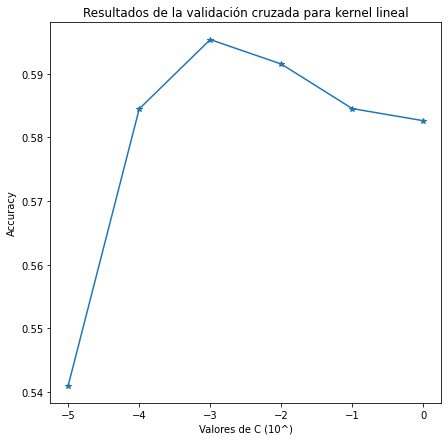

In [31]:
plt.figure(figsize=(7,7))
plt.plot(np.log10(Cs), grid.cv_results_['mean_test_score'],'*-')
plt.title('Resultados de la validación cruzada para kernel lineal')
plt.xlabel('Valores de C (10^)')
plt.ylabel('Accuracy')

## Eligiendo C y Gamma para el kernel RBF con GridSearch

In [32]:
# función auxiliar que muestra los parámetros del gridsearch
def mostrar_grid_search_results(rangoC, rangoGamma, resultados):
    '''
    Entrada:
        rangoC: lista con los valores de C evaluados
        rangoGamma: lista con los valores de gamma evaluados
        resultados: arrglo de tamaño (len(rangoC),len(rangoGamma)) con los resultados
                    del grid-search
    '''
    fig, ax = plt.subplots()
    im = ax.imshow(resultados, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    ax.set_ylabel('C')
    ax.set_ylim(-0.5,len(rangoC)-0.5)
    ax.set_xlim(-0.5,len(rangoGamma)-0.5)
    ax.set_yticks(range(len(rangoC)))
    ax.set_xticks(range(len(rangoGamma)))
    rangoC_labels = [str(c) for c in rangoC]
    ax.set_yticklabels(rangoC_labels)
    ax.set_xlabel('Gamma')
    rangoGamma_labels = [str(gamma) for gamma in rangoGamma]
    ax.set_xticklabels(rangoGamma_labels)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
                    rotation_mode="anchor")
    plt.title('Resultados del Grid Search')

**Ejercicio:** Realizar la búsqueda de parámetros óptimos para la grilla de valores de $C$ y $\gamma$ que se indica a continuación.

In [33]:
# Se construye la grilla para hacer el grid-search
# Es habitual usar una grilla logarítmica en base 10 en una primera
# pasada y luego refinarla con una búsqueda lineal o en base 2 (mas costoso)

Cs = np.logspace(-2, 7, 4)  
gammas = np.logspace(-9, -3, 5)

####################################################################################################################
#################   EMPIEZA ESPACIO PARA COMPLETAR CODIGO  #########################################################
####################################################################################################################

# Se define el diccionario con los parámetros a probar, en este caso solo C
param_grid= {'C' : Cs, 'gamma' : gammas}

# Se realiza la división del conjunto de entrenamiento en los 6 folds
cv = PredefinedSplit(test_fold=fold_indices_train)

# Se define la validación cruzada a realizar para el kernel lineal
grid = GridSearchCV(svm.SVC(kernel='linear'), param_grid=param_grid, 
                    cv=cv, verbose=3, n_jobs=-1)

# Se realiza la búsqueda de parámetros
grid.fit(features_train, labels_train)

print("Los mejores parámetros fueron %s con un accuracy de %0.3f"
      % (grid.best_params_, grid.best_score_))

####################################################################################################################
#################   TERMINA ESPACIO PARA COMPLETAR CODIGO  #########################################################
####################################################################################################################



Fitting 6 folds for each of 20 candidates, totalling 120 fits
[CV] C=0.01, gamma=1e-09 .............................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................. C=0.01, gamma=1e-09, score=0.580, total=   4.4s
[CV] C=0.01, gamma=1e-09 .............................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.4s remaining:    0.0s


[CV] ................. C=0.01, gamma=1e-09, score=0.511, total=   4.3s
[CV] C=0.01, gamma=1e-09 .............................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    8.7s remaining:    0.0s


[CV] ................. C=0.01, gamma=1e-09, score=0.523, total=   4.1s
[CV] C=0.01, gamma=1e-09 .............................................
[CV] ................. C=0.01, gamma=1e-09, score=0.671, total=   4.5s
[CV] C=0.01, gamma=1e-09 .............................................
[CV] ................. C=0.01, gamma=1e-09, score=0.623, total=   4.3s
[CV] C=0.01, gamma=1e-09 .............................................
[CV] ................. C=0.01, gamma=1e-09, score=0.642, total=   5.1s
[CV] C=0.01, gamma=3.162277660168379e-08 .............................
[CV] . C=0.01, gamma=3.162277660168379e-08, score=0.580, total=   5.2s
[CV] C=0.01, gamma=3.162277660168379e-08 .............................
[CV] . C=0.01, gamma=3.162277660168379e-08, score=0.511, total=   4.8s
[CV] C=0.01, gamma=3.162277660168379e-08 .............................
[CV] . C=0.01, gamma=3.162277660168379e-08, score=0.523, total=   3.9s
[CV] C=0.01, gamma=3.162277660168379e-08 .............................
[CV] .

[CV] .............. C=10000.0, gamma=1e-09, score=0.567, total=  17.0s
[CV] C=10000.0, gamma=1e-09 ..........................................
[CV] .............. C=10000.0, gamma=1e-09, score=0.502, total=  12.1s
[CV] C=10000.0, gamma=1e-09 ..........................................
[CV] .............. C=10000.0, gamma=1e-09, score=0.512, total=   7.1s
[CV] C=10000.0, gamma=1e-09 ..........................................
[CV] .............. C=10000.0, gamma=1e-09, score=0.668, total=  24.6s
[CV] C=10000.0, gamma=1e-09 ..........................................
[CV] .............. C=10000.0, gamma=1e-09, score=0.627, total=  14.6s
[CV] C=10000.0, gamma=1e-09 ..........................................
[CV] .............. C=10000.0, gamma=1e-09, score=0.618, total=  34.3s
[CV] C=10000.0, gamma=3.162277660168379e-08 ..........................
[CV]  C=10000.0, gamma=3.162277660168379e-08, score=0.567, total=  18.1s
[CV] C=10000.0, gamma=3.162277660168379e-08 ..........................
[CV]

[CV] ........... C=10000000.0, gamma=0.001, score=0.627, total=  13.5s
[CV] C=10000000.0, gamma=0.001 .......................................
[CV] ........... C=10000000.0, gamma=0.001, score=0.618, total=  31.8s


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed: 29.8min finished


Los mejores parámetros fueron {'C': 0.01, 'gamma': 1e-09} con un accuracy de 0.592


**Pregunta:** ¿Cuáles fueron los parámetros óptimos de $C$ y $\gamma$ para la grilla sugerida?

**Respuesta:**

Lo parametros optimos fueron C = 0.01 y $\gamma$ = 1e-09

Una vez realizada la búsqueda se muestran los valores óptimos. Además se puede acceder a información detallada de la búsqueda a través de los atributos del objeto *GridSearchCV*.  

In [34]:
# El mejor clasificador encontrado 
best_clf_rbf = grid.best_estimator_
# Detalle de la validación cruzada a través del diccionario cv_results_
print('Claves del diccionario que almacena los resultados:')
print(grid.cv_results_.keys())

Claves del diccionario que almacena los resultados:
dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_C', 'param_gamma', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'split5_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])


[[0.59154011 0.59154011 0.59154011 0.59154011 0.59154011]
 [0.58249625 0.58249625 0.58249625 0.58249625 0.58249625]
 [0.58249625 0.58249625 0.58249625 0.58249625 0.58249625]
 [0.58249625 0.58249625 0.58249625 0.58249625 0.58249625]]


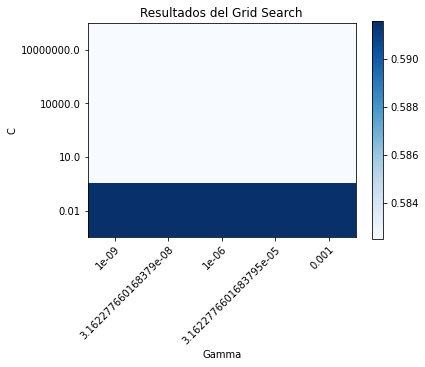

In [35]:
# Se muestran los resultados del grid-search
resultados = grid.cv_results_['mean_test_score']
resultados = resultados.reshape(len(Cs),len(gammas))
print(resultados)
mostrar_grid_search_results(Cs, gammas, resultados)

## Evaluación de los mejores clasificadores con el conjunto de validación

In [36]:
acc_val_linear = best_clf_linear.score(features_val, labels_val)
print('El accuracy con el conjunto de validación utilizando kernel linear es: % .03f' % acc_val_linear)
acc_val_rbf = best_clf_rbf.score(features_val, labels_val)
print('El accuracy con el conjunto de validación utilizando kernel rbf es: % .03f' % acc_val_rbf)

El accuracy con el conjunto de validación utilizando kernel linear es:  0.668
El accuracy con el conjunto de validación utilizando kernel rbf es:  0.659


**Pregunta:** Si tuviera que entregar el clasificador en este momento ¿Cuál entregaría?

A continuación se muestra la matriz de confusión con el conjunto de validación. 

In [37]:
# funcion auxiliar (Ejecutar y seguir)
def mostrar_matriz_confusion(cm, target_names,
                            normalize=False,
                            cmap=plt.cm.Blues):
    '''
    Muestra la matriz de confusión
    '''

    fig, ax = plt.subplots(figsize=(10,10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
            yticks=np.arange(cm.shape[0]),
            xticklabels=target_names, yticklabels=target_names,
            title= 'Matriz de confusion normalizada' if normalize else 'Matriz de confusion sin normalizar',
            ylabel='Etiqueta',
            xlabel='Predicción',
            xlim=(-0.5,9.5),
            ylim=(9.5,-0.5))

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
                rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()

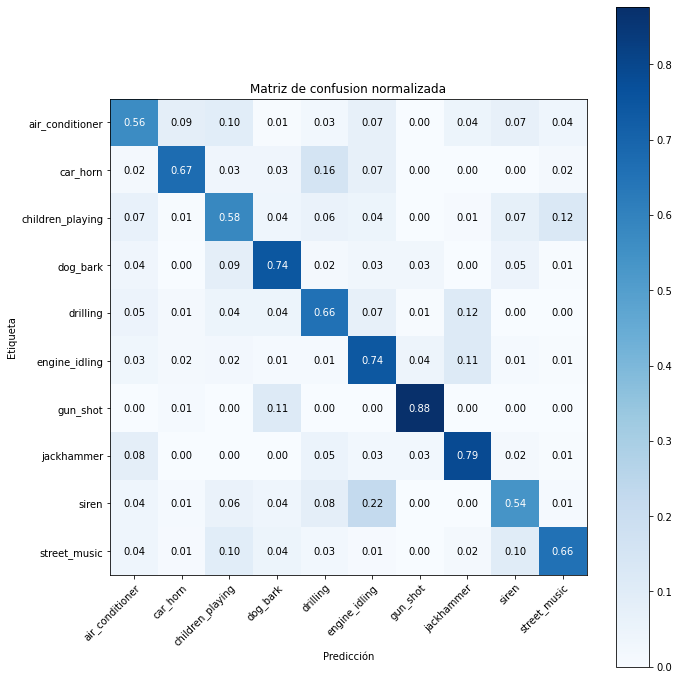

In [38]:
# Matriz de confusión utilizando kernel linear
y_pred = best_clf_linear.predict(features_val)
clases = ('air_conditioner', 'car_horn', 'children_playing', 'dog_bark', 
           'drilling', 'engine_idling', 'gun_shot', 'jackhammer', 'siren', 
           'street_music')
cm = confusion_matrix(labels_val, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
mostrar_matriz_confusion(cm_normalized, clases, normalize=True)

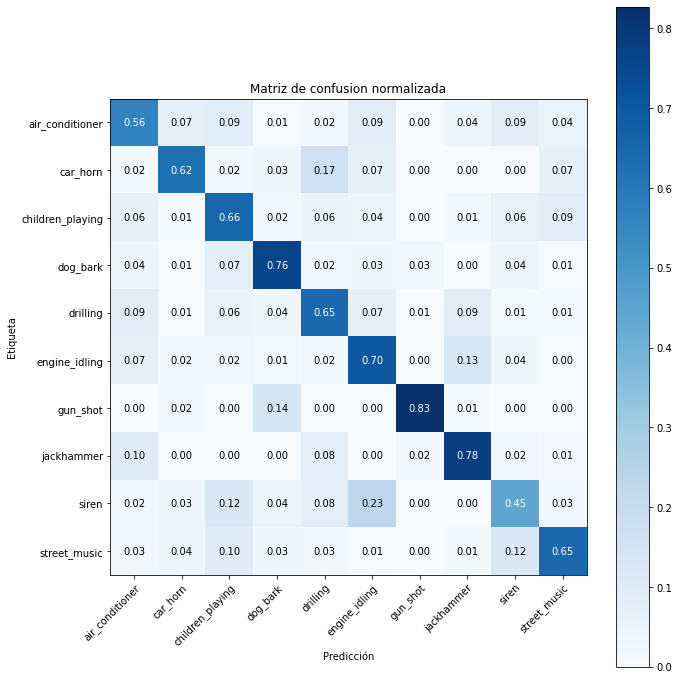

In [39]:
# Matriz de confusión utilizando kernel rbf
y_pred = best_clf_rbf.predict(features_val)
clases = ('air_conditioner', 'car_horn', 'children_playing', 'dog_bark', 
           'drilling', 'engine_idling', 'gun_shot', 'jackhammer', 'siren', 
           'street_music')
cm = confusion_matrix(labels_val, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
mostrar_matriz_confusion(cm_normalized, clases, normalize=True)

## Mejorando el clasificador SVM

Un primer objetivo es el de mejorar los clasificadores SVM base ya entrenados. Algunas posibilidades que se pueden explorar a dichos efectos son:
- Refinar la grilla de búsqueda de parámetros óptimos 
- Explorar la utilización de otro kernel
- Evaluar el impacto de aplicar algún preprocesamiento de características

En unos días se habilitará una tarea en el eva para subir las predicciones realizadas sobre el conjunto de test. 